# CDSDS 542 Deep Learning for Data Science - Discussion 5: Measuring Performance


[![](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/DL4DS/fa2026_discussions/blob/main/discussion_5.ipynb)

In discussion 5, we talking about measuring performance. Deep learning models can fit almost any dataset given enough layers and parameters. This flexibility is both a strength and a risk because it allows networks to capture complex patterns,  but also makes them prone to **overfitting**, where the model memorizes training examples instead of learning general rules.

To design reliable deep models, we need to understand how dataset and model structure affects performance. For training large neural networks that **generalize** well to unseen data.

### Review Noise, Bias, Variance and Expected Prediction Error
Let the true relationship between input $x$ and target $y$ be:

$$
y = f^*(x) + \varepsilon,
$$
where  

- $f^*(x)$ is the true (unknown) function generating the data,  
- $\varepsilon$ is random noise with $\mathbb{E}[\varepsilon] = 0$ and variance $\mathrm{Var}[\varepsilon] = \sigma^2$.

Model $f(x; \phi)$ is trained on a dataset $D = \{(x_i, y_i)\}$, producing learned parameters $\phi_D$.  
Since the dataset $D$ is random, the fitted model itself is a **random function**.

**Expected Prediction Error**

For a given input $x$, the **expected squared test error** over all possible datasets and noise realizations is:

$$
\mathbb{E}_{D,\varepsilon}\left[(y - f(x; \phi_D))^2\right]
$$

Expanding this gives the **bias–variance–noise decomposition**:

$$
\mathbb{E}_{D,\varepsilon}[(y - f(x; \phi_D))^2]
= \underset{\text{Bias}^2}{(\mathbb{E}_D[f(x; \phi_D)] - f^*(x))^2}
+ \underset{\text{Variance}}{\mathbb{E}_D[(f(x; \phi_D) - \mathbb{E}_D[f(x; \phi_D)])^2]} + \underset{\text{Noise}}{\sigma^2}
$$

**Notice:**
This equation is only algebraically exact for mean square error (**MSE**), but this bias-variance relationship can also be conceptual explanation for other loss (e.g. cross-entropy, MAE, Hinge).

However, No matter which loss function you choose, the generalization errors of the model can be understood from the following three aspects:

**Generalization Error = Systematic error ("Bias") + Sensitivity to training data ("Variance") + Irreducible randomness ("Noise")**

Just under different losses, the measurement methods of these three items are different, and they may not be "additive" mathematically.

Let's start with an example.

## 1. Set Up Dataset


In [2]:
# Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load dataset
df = pd.read_csv("https://github.com/npradaschnor/Pima-Indians-Diabetes-Dataset/raw/refs/heads/master/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Here we split the train, validation, test set with 6:2:2

In [5]:
train_val, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42)  # 60/20/20 split
print("train: ", len(train), "val:", len(val), "test:", len(test))

X_train_raw = train.drop("Outcome", axis=1).values
y_train = train["Outcome"].values
X_val_raw = val.drop("Outcome", axis=1).values
y_val = val["Outcome"].values
X_test = test.drop("Outcome", axis=1).values
y_test = test["Outcome"].values

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test)


# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=32, shuffle=False)

train:  460 val: 154 test: 154


## 2. Noise

$$
\text{Noise}(x) = \mathrm{Var}[\varepsilon] = \sigma^2
$$

Noise is the part of prediction error that not the model can remove.
Even with perfect training, real-world data often contain:
- **Label noise** (mislabeling, annotation mistakes),
- **Measurement noise** (sensor or recording errors),
- **Intrinsic randomness** (human or environmental variability).

We usually remove incorrect labels or abnormal samples by cleaning the data and conducting noise reduction preprocessing to reduce the errors caused by noise.


## 3. Bias

$$
\text{Bias}(x) = \mathbb{E}_D[f(x; \phi_D)] - f^*(x)
$$

Bias means how far the *average model prediction* is from the *true function*.  When model too simple (underfitting), it sometimes cause large bias. In deep learning, this often means the network has **insufficient capacity** (simple network structure) or **poor training** (not enough training epoch).

### Demo 1
Try to reduce bias (systematic error) by increasing model capacity. Understand how a more expressive neural network can reduce bias and fit the data more accurately.

In [4]:
class Network_A(nn.Module): # A very simple network, almost closed to logistic regression
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

class Network_B(nn.Module):  # Improved network, deeper & wider
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)


def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3, device="cpu"):

    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_acc_hist, val_acc_hist = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        # Evaluate
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train_t.to(device)).cpu().numpy()
            y_pred_val = model(X_val_t.to(device)).cpu().numpy()
            train_acc = accuracy_score(y_train, (y_pred_train > 0.5))
            val_acc = accuracy_score(y_val, (y_pred_val > 0.5))
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)
    return train_acc_hist, val_acc_hist

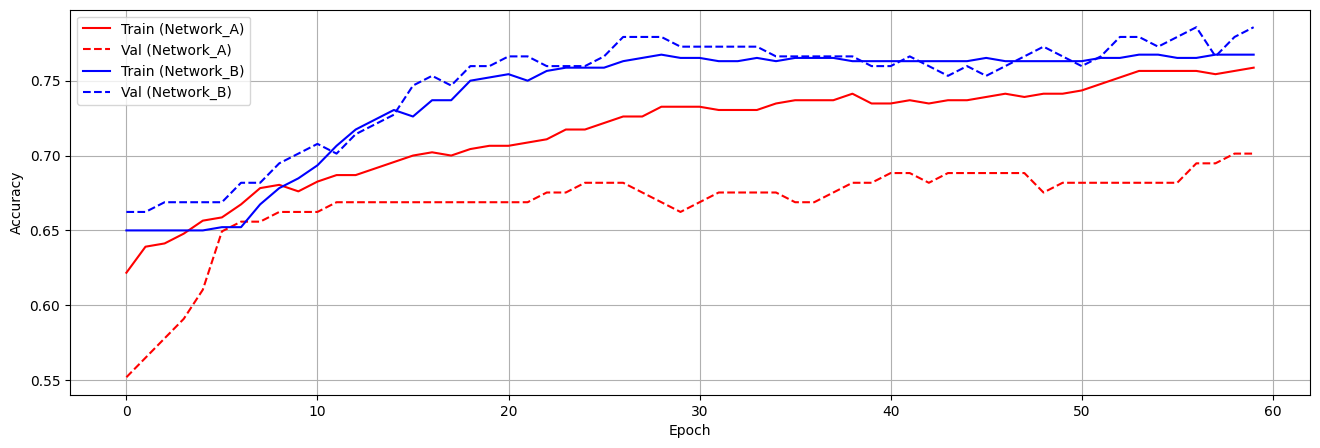

In [65]:
# train
device = "cuda" if torch.cuda.is_available() else "cpu"
model_small = Network_A(X_train.shape[1])
model_big = Network_B(X_train.shape[1])

train_A, val_A = train_model(model_small, train_loader, val_loader, epochs=60, lr=1e-3, device=device)
train_B, val_B = train_model(model_big, train_loader, val_loader, epochs=60, lr=1e-3, device=device)

# plot
plt.figure(figsize=(16,5))
plt.plot(train_A, "r-", label="Train (Network_A)")
plt.plot(val_A, "r--", label="Val (Network_A)")
plt.plot(train_B, "b-", label="Train (Network_B)")
plt.plot(val_B, "b--", label="Val (Network_B)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Interpretation of the Learning Curves:

**Red line (Network A):** Smaller network (fewer parameters → weaker representation power → higher bias).

**Blue line (Network B):** Larger network (more parameters → stronger representation ability → lower bias).

For the smaller network, overall accuracy is lower. The model “learns slowly" because its capacity is too small to capture the underlying data patterns.

Also, you can see training and validation curves almost overlap. Model performs similarly on training and validation data, which means it has failed to learn complex relationships — it neither memorizes details nor captures deeper patterns. Shows **underfitting**.


In [7]:
# Evaluate with test data
def evaluate(model, X, y, device="cpu"):
    model.eval()
    with torch.no_grad():
        preds = model(X.to(device)).cpu().numpy()
        acc = accuracy_score(y, preds > 0.5)
    return acc

test_acc_A = evaluate(model_small, X_test_t, y_test_t, device)
test_acc_B = evaluate(model_big, X_test_t, y_test_t, device)

print(f"Test Accuracy (Network_A): {test_acc_A:.3f}")
print(f"Test Accuracy (Network_B): {test_acc_B:.3f}")

Test Accuracy (Network_A): 0.708
Test Accuracy (Network_B): 0.773


## 4. Variance

$$
\text{Variance}(x) = \mathbb{E}_D\left[(f(x; \phi_D) - \mathbb{E}_D[f(x; \phi_D)])^2\right]
$$

**Variance** is how much model predictions fluctuate across different training datasets.  

If the performance shows large variance, the model is likely to be too sensitive to training data (**overfitting**).  In deep learning, excessive parameters, lack of regularization, or small datasets increase variance.

### Demo 2

In the previous exercise, we saw that increasing model capacity helps reduce *bias*.  However, if we keep making the network more complex or train it too long, it starts to **memorize** the training data — this is *high variance*, or **overfitting**.

In [67]:
class Network_C(nn.Module): # Very large model, prone to overfitting.
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)


class Network_D(nn.Module): # Same size, but with dropout to control variance.
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)


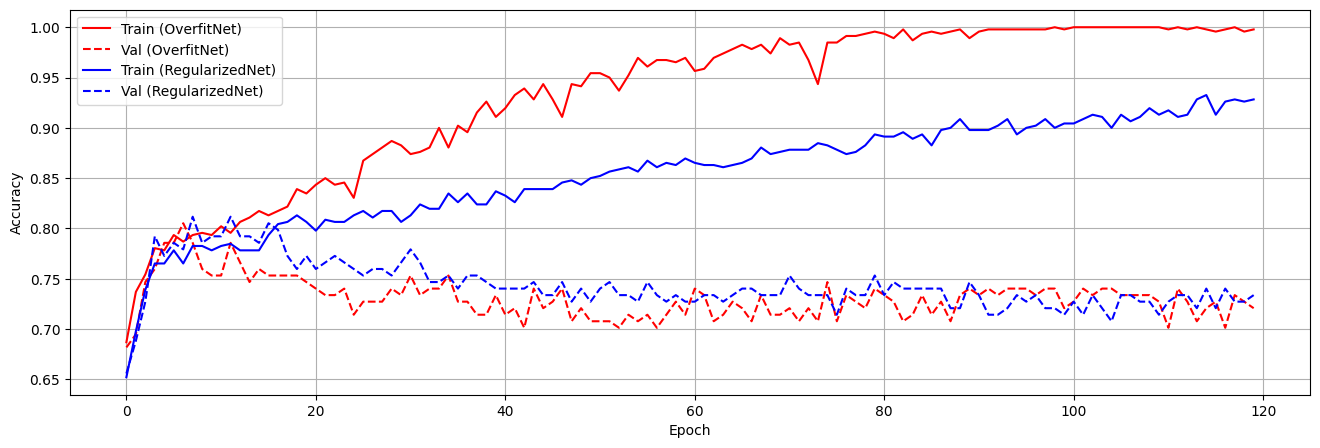

In [71]:
# train
device = "cuda" if torch.cuda.is_available() else "cpu"
model_overfit = Network_C(X_train.shape[1])
model_reg = Network_D(X_train.shape[1])

train_C, val_C = train_model(model_overfit, train_loader, val_loader, epochs=120, lr=1e-3, device=device)
train_D, val_D = train_model(model_reg, train_loader, val_loader, epochs=120, lr=1e-3, device=device)

plt.figure(figsize=(16,5))
plt.plot(train_C, "r-", label="Train (Network_C)")
plt.plot(val_C, "r--", label="Val (Network_C)")
plt.plot(train_D, "b-", label="Train (Network_D)")
plt.plot(val_D, "b--", label="Val (Network_D)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Evaluate with test data

test_acc_C = evaluate(model_overfit, X_test_t, y_test_t, device)
test_acc_D = evaluate(model_reg, X_test_t, y_test_t, device)

print(f"Test Accuracy (Network_C): {test_acc_C:.3f}")
print(f"Test Accuracy (Network_D): {test_acc_D:.3f}")

Test Accuracy (Network_C): 0.668
Test Accuracy (Network_D): 0.714


Interpretation of the Learning Curves:

**Red lines (Network_C):**
Large network → high capacity → low bias. Training accuracy quickly reaches 1.0, but validation accuracy stagnates or drops. Which means model memorizes training data, results in a high variance / overfitting.

**Blue lines (Network_D):**
Same architecture with dropout layers. Training and validation accuracy rise together and stabilize. The dropout reduces neuron co-adaptation and noise sensitivity. So that variance decreases, and model generalization improves.

Regularization slightly increases bias but greatly reduces variance, model achieves a more stable fit and better generalization ability.

Summary and some frequently used techniques for training:

![Bias–Variance Tradeoff](https://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png)

Understanding Bias and Variance: https://scott.fortmann-roe.com/docs/BiasVariance.html

| Technique                                             | Primarily Targets                   | Principle                                                                            | Effect on Bias                                          | Effect on Variance                             | Effect on Noise                                         |
| ----------------------------------------------------- | ----------------------------------- | ------------------------------------------------------------------------------------ | ------------------------------------------------------- | ---------------------------------------------- | ------------------------------------------------------- |
| **Regularization (L1 / L2, Weight Decay)**            |  **High Variance**                | Constrains parameter magnitude to prevent overfitting to training samples            | ↑ Slightly increases (model becomes simpler)            | ↓ Significantly decreases (limits overfitting) |  Indirectly helps by discouraging fitting to noise    |
| **Dropout**                                           |  **High Variance**                | Randomly disables neurons, breaking co-adaptation and enforcing robustness           | ↑ Slightly increases                                    | ↓ Strongly decreases                           |  Indirectly helps by preventing memorization of noise |
| **Data Augmentation**                                 |  **High Variance + Limited Data** | Expands data diversity (flip, rotate, add noise, resample) to improve generalization | ↓ Decreases (more data allows fitting complex patterns) | ↓ Decreases (more stable gradient updates)     |  Mitigates random noise effects through diversity     |
| **Early Stopping**                                    |  **High Variance**                | Stops training before validation performance drops, avoiding memorization of noise   |  Nearly unchanged                                     | ↓ Decreases noticeably                         |  Helps prevent fitting training noise                 |
| **Increasing Model Capacity (More Layers / Neurons)** |  **High Bias**                    | Enhances expressive power to capture complex relationships                           | ↓ Decreases                                             | ↑ May increase                                 | No direct impact on noise                            |
| **Data Cleaning / Denoising Preprocessing**           |  **High Noise**                   | Removes mislabeled or corrupted samples                                              |  No direct effect                                     |  No direct effect                            | ↓ Greatly reduces noise-induced errors                  |

---

For example:

* **To address *Bias***

  * Increase model complexity (deeper networks, nonlinear layers, feature engineering)
  * Train longer or use better optimization methods
  * Collect more informative or richer features

* **To address *Variance***

  * Apply regularization (L2, dropout, batch normalization, early stopping)
  * Increase training data or use data augmentation
  * Use ensembles to average out individual model fluctuations

* **To address *Noise***

  * Clean data (remove mislabeled or anomalous samples)
  * Use robust loss functions (e.g., Huber loss, label smoothing)
  * Gather more and higher-quality data to smooth out noise effects

# Exercise — Achieving the Bias–Variance Trade-off

Now that we understand bias, variance, and noise,
we’ll combine all our tools to find where the model generalizes best.

Goal: maximize test accuracy. (>65%)

In [115]:
# TODO: define your network
class Network_Exercise(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            __fill__
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)


# TODO: refine the training process
def train_model(model, train_loader, val_loader, epochs=60, lr=1e-3, device="cpu"):

    model = model.to(device)
    criterion = __fill__
    optimizer = __fill__

    train_acc_hist, val_acc_hist = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        # Evaluate
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train_t.to(device)).cpu().numpy()
            y_pred_val = model(X_val_t.to(device)).cpu().numpy()
            train_acc = accuracy_score(y_train, (y_pred_train > 0.5))
            val_acc = accuracy_score(y_val, (y_pred_val > 0.5))
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

    return train_acc_hist, val_acc_hist

In [9]:
# TODO: output

# train
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Network_Exercise(X_train.shape[1])
train_hist, val_hist = train_model(model, train_loader, val_loader, epochs=__fill__, lr=__fill__, device=device)

# Evaluate with test data
def evaluate(model, X, y, device="cpu"):
    model.eval()
    with torch.no_grad():
        preds = model(X.to(device)).cpu().numpy()
        acc = accuracy_score(y, preds > 0.5)
    return acc

test_acc = evaluate(model, X_test_t, y_test_t, device)
print(f"Final Test Accuracy: {test_acc:.3f}")

# plot
plt.figure(figsize=(8,5))
plt.plot(train_hist, "r-", label="Train Accuracy")
plt.plot(val_hist, "b--", label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()